In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Train_path = '/content/drive/My Drive/DataSet_Work/Anaconda1/Train'
Val_path = '/content/drive/My Drive/DataSet_Work/Anaconda1/Valid'

# Prepare your data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    Train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    Val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 3013 images belonging to 2 classes.
Found 1062 images belonging to 2 classes.


In [7]:
import tensorflow as tf
from model import EfficientNetV2_S  # Import the model you want to use
from tensorflow.keras import layers, models
# Build the model
base_model = EfficientNetV2_S(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Verify the output shape of the base model
# Build the final model
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)

# If the output is already flattened (as in the shape is (None, 1280)), skip the pooling
if len(base_model.output_shape) == 4:  # If the output is 4D, apply GlobalAveragePooling2D
    x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/content/model.py:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if mb_type is 'normal':


82730696/82730696 [==============================] - 0s 0us/step
(None, 1280)


In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=2
)

Epoch 1/2
94/94 [==============================] - 2175s 22s/step - loss: 0.8919 - accuracy: 0.5304 - val_loss: 0.6944 - val_accuracy: 0.4460
Epoch 2/2
94/94 [==============================] - 1997s 21s/step - loss: 0.6919 - accuracy: 0.5411 - val_loss: 0.6960 - val_accuracy: 0.4460


Found 700 images belonging to 2 classes.
22/22 [==============================] - 155s 7s/step
              precision    recall  f1-score   support

           0       0.37      1.00      0.54       260
           1       0.00      0.00      0.00       440

    accuracy                           0.37       700
   macro avg       0.19      0.50      0.27       700
weighted avg       0.14      0.37      0.20       700



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


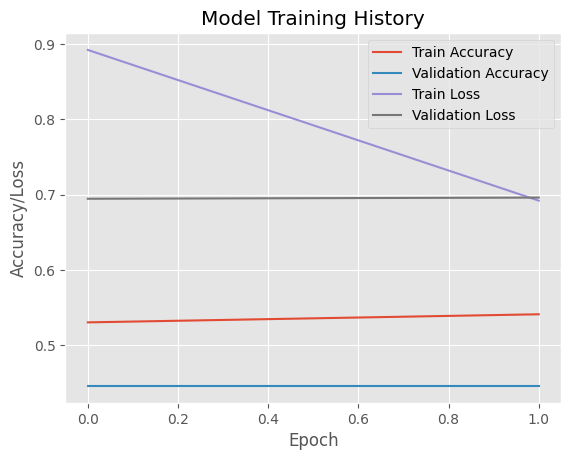

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Set ggplot style
matplotlib.style.use('ggplot')

# Assuming test data is in 'test_dir' directory
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/DataSet_Work/Anaconda1/Test',  # Replace with your test directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Adjust based on your problem
    shuffle=False
)

# Get the number of samples in the test set
num_samples = test_generator.samples

# Predict on the test data directly using the generator
y_pred = model.predict(test_generator)

# Convert predictions to binary class labels (adjust threshold if needed)
pred = np.argmax(y_pred, axis=1)  # Select class with highest probability

# Get true labels from the generator
y_test = test_generator.classes

# Print classification report
print(classification_report(y_test, pred))

# Plot training history
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.savefig('training_history.png')
plt.show()